In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Cria a Spark Session
spark = SparkSession.builder \
    .appName("App-Eng-Spark-Haoop") \
    .master("spark://spark:7077") \
    .getOrCreate() 

In [2]:
# Lê o arquivo CSV
df = spark.read.csv("hdfs://namenode:9000/result-ele2022.csv", sep=";", encoding="ISO-8859-1", header=True, inferSchema=True)

# Mostra o número de linhas no arquivo
df.count()

878328

In [3]:
# Descreve o conjunto de dados do dataset
df.describe()

DataFrame[summary: string, DT_GERACAO: string, ANO_ELEICAO: string, CD_TIPO_ELEICAO: string, NM_TIPO_ELEICAO: string, CD_PLEITO: string, DT_PLEITO: string, NR_TURNO: string, CD_ELEICAO: string, DS_ELEICAO: string, SG_UF: string, CD_MUNICIPIO: string, NM_MUNICIPIO: string, NR_ZONA: string, NR_SECAO: string, NR_LOCAL_VOTACAO: string, CD_CARGO_PERGUNTA: string, DS_CARGO_PERGUNTA: string, NR_PARTIDO: string, SG_PARTIDO: string, NM_PARTIDO: string, DT_BU_RECEBIDO: string, QT_APTOS: string, QT_COMPARECIMENTO: string, QT_ABSTENCOES: string, CD_TIPO_URNA: string, DS_TIPO_URNA: string, CD_TIPO_VOTAVEL: string, DS_TIPO_VOTAVEL: string, NR_VOTAVEL: string, NM_VOTAVEL: string, QT_VOTOS: string, NR_URNA_EFETIVADA: string, CD_CARGA_1_URNA_EFETIVADA: string, CD_CARGA_2_URNA_EFETIVADA: string, CD_FLASHCARD_URNA_EFETIVADA: string, DT_CARGA_URNA_EFETIVADA: string, DS_CARGO_PERGUNTA_SECAO: string, DS_AGREGADAS: string, DT_ABERTURA: string, DT_ENCERRAMENTO: string, QT_ELEITORES_BIOMETRIA_NH: string, DT_EM

In [4]:
# Lista os dados
df.show(3)

+----------+-------------------+-----------+---------------+-----------------+---------+----------+--------+----------+--------------------+-----+------------+------------+-------+--------+----------------+-----------------+-----------------+----------+----------+--------------------+-------------------+--------+-----------------+-------------+------------+------------+---------------+---------------+----------+------------+--------+-----------------+-------------------------+-------------------------+---------------------------+-----------------------+-----------------------+------------+-------------------+-------------------+-------------------------+-------------------+------------------+------------------+
|DT_GERACAO|         HH_GERACAO|ANO_ELEICAO|CD_TIPO_ELEICAO|  NM_TIPO_ELEICAO|CD_PLEITO| DT_PLEITO|NR_TURNO|CD_ELEICAO|          DS_ELEICAO|SG_UF|CD_MUNICIPIO|NM_MUNICIPIO|NR_ZONA|NR_SECAO|NR_LOCAL_VOTACAO|CD_CARGO_PERGUNTA|DS_CARGO_PERGUNTA|NR_PARTIDO|SG_PARTIDO|          NM_PA

In [5]:
# Lista a estrutura dos dados
df.printSchema()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: timestamp (nullable = true)
 |-- ANO_ELEICAO: integer (nullable = true)
 |-- CD_TIPO_ELEICAO: integer (nullable = true)
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- CD_PLEITO: integer (nullable = true)
 |-- DT_PLEITO: string (nullable = true)
 |-- NR_TURNO: integer (nullable = true)
 |-- CD_ELEICAO: integer (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CD_MUNICIPIO: integer (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- NR_SECAO: integer (nullable = true)
 |-- NR_LOCAL_VOTACAO: integer (nullable = true)
 |-- CD_CARGO_PERGUNTA: integer (nullable = true)
 |-- DS_CARGO_PERGUNTA: string (nullable = true)
 |-- NR_PARTIDO: integer (nullable = true)
 |-- SG_PARTIDO: string (nullable = true)
 |-- NM_PARTIDO: string (nullable = true)
 |-- DT_BU_RECEBIDO: string (nullable = true)
 |-- QT_APTOS: integer (nullable

In [6]:
# Verifica as colunas vazias

from pyspark.sql.functions import col, sum

vazias = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Exibe o resultado
vazias.show(vertical=True)

-RECORD 0--------------------------
 DT_GERACAO                  | 0   
 HH_GERACAO                  | 0   
 ANO_ELEICAO                 | 0   
 CD_TIPO_ELEICAO             | 0   
 NM_TIPO_ELEICAO             | 0   
 CD_PLEITO                   | 0   
 DT_PLEITO                   | 0   
 NR_TURNO                    | 0   
 CD_ELEICAO                  | 0   
 DS_ELEICAO                  | 0   
 SG_UF                       | 0   
 CD_MUNICIPIO                | 0   
 NM_MUNICIPIO                | 0   
 NR_ZONA                     | 0   
 NR_SECAO                    | 0   
 NR_LOCAL_VOTACAO            | 0   
 CD_CARGO_PERGUNTA           | 0   
 DS_CARGO_PERGUNTA           | 0   
 NR_PARTIDO                  | 0   
 SG_PARTIDO                  | 0   
 NM_PARTIDO                  | 0   
 DT_BU_RECEBIDO              | 0   
 QT_APTOS                    | 0   
 QT_COMPARECIMENTO           | 0   
 QT_ABSTENCOES               | 0   
 CD_TIPO_URNA                | 0   
 DS_TIPO_URNA               

In [7]:
# Verifica quais os turnos estão no dataframe
df.select("NR_TURNO").distinct().show()

+--------+
|NR_TURNO|
+--------+
|       1|
+--------+



In [8]:
# Verifica quais unidades da federação estão no dataframe
df.select("SG_UF").distinct().show()

+-----+
|SG_UF|
+-----+
|   RN|
+-----+



### Calcular taxa de comparecimento por Município
#### Deduplicar as entradas das seções eleitorais

In [9]:
df_secao = (
    df
    .select("NR_ZONA","NM_MUNICIPIO","NR_SECAO","QT_APTOS","QT_COMPARECIMENTO")
    .distinct()
    .orderBy("NR_ZONA","NM_MUNICIPIO","NR_SECAO")
)

#### Aptos e comparecimento por município

In [10]:
df_aptos_comp = (
    df_secao
    .groupBy("NM_MUNICIPIO")
    .agg(F.sum("QT_APTOS").alias("APTOS"), F.sum("QT_COMPARECIMENTO").alias("COMPARECIMENTO"))
    .orderBy("NM_MUNICIPIO")
)

#### Taxa de Comparecimento por Município

In [11]:
df_taxa_municipio = (
    df_aptos_comp
    .withColumn("TAXA_COMPARECIMENTO", F.format_number( 100 * F.col("COMPARECIMENTO") / F.col("APTOS"),2))
)    

In [12]:
df_taxa_municipio.show()

+-----------------+-----+--------------+-------------------+
|     NM_MUNICIPIO|APTOS|COMPARECIMENTO|TAXA_COMPARECIMENTO|
+-----------------+-----+--------------+-------------------+
|            ACARI| 9204|          7415|              80.56|
|   AFONSO BEZERRA| 9841|          7983|              81.12|
|       ALEXANDRIA|12131|          9831|              81.04|
|    ALMINO AFONSO| 5304|          4465|              84.18|
|ALTO DO RODRIGUES|11576|          9370|              80.94|
|          ANGICOS|10489|          8727|              83.20|
|  ANTÔNIO MARTINS| 5864|          5050|              86.12|
|            APODI|29553|         25334|              85.72|
|     AREIA BRANCA|21617|         17382|              80.41|
|             AREZ|11642|          9798|              84.16|
|             ASSÚ|44108|         36352|              82.42|
|          BARAÚNA|21307|         17483|              82.05|
|        BARCELONA| 4628|          3763|              81.31|
|     BAÍA FORMOSA| 8109

#### Município com Menor taxa de comparecimento

In [13]:
df_taxa_municipio.orderBy(F.col("TAXA_COMPARECIMENTO")).limit(1).show()

+-------------+-----+--------------+-------------------+
| NM_MUNICIPIO|APTOS|COMPARECIMENTO|TAXA_COMPARECIMENTO|
+-------------+-----+--------------+-------------------+
|PEDRO AVELINO| 6605|          4891|              74.05|
+-------------+-----+--------------+-------------------+



#### Município com Maior taxa de comparecimento

In [14]:
df_taxa_municipio.orderBy(F.col("TAXA_COMPARECIMENTO").desc()).limit(1).show()

+------------+-----+--------------+-------------------+
|NM_MUNICIPIO|APTOS|COMPARECIMENTO|TAXA_COMPARECIMENTO|
+------------+-----+--------------+-------------------+
|    PASSAGEM| 4057|          3585|              88.37|
+------------+-----+--------------+-------------------+



## Desempenho partidário no Estado - Deputado Federal

In [15]:
df_partido_depfed = (
    df
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","SG_PARTIDO","QT_VOTOS")
    .filter(F.col("CD_CARGO_PERGUNTA")==6)
    .filter(F.col("SG_PARTIDO")!="#NULO#")
    .groupBy("SG_PARTIDO").agg(F.sum("QT_VOTOS").alias("TOTAL_VOTOS_PARTIDO"))
    .orderBy(F.col("TOTAL_VOTOS_PARTIDO").desc())
    .withColumn("TOTAL_VOTOS_PARTIDO", F.regexp_replace(F.format_number("TOTAL_VOTOS_PARTIDO", 0),",","." ))
    .show(100)
)

+-------------+-------------------+
|   SG_PARTIDO|TOTAL_VOTOS_PARTIDO|
+-------------+-------------------+
|           PL|            370.465|
|        UNIÃO|            315.590|
|           PT|            293.953|
|          MDB|            176.527|
|SOLIDARIEDADE|            169.556|
|           PP|            153.061|
| REPUBLICANOS|            104.424|
|          PSB|            100.539|
|         PSDB|             51.588|
|          PSD|             26.590|
|          PDT|             22.404|
|           PV|             17.865|
|          PSC|             14.573|
|         PODE|             14.042|
|       AVANTE|              8.916|
|      PC do B|              4.889|
|    CIDADANIA|              4.315|
|          PTB|              3.915|
|         PSOL|              3.785|
|     PATRIOTA|              3.588|
|          PMN|              2.314|
|           DC|              2.094|
|          PMB|              2.016|
|         PRTB|              1.285|
|         REDE|             

## Desempenho partidário nos Municípios: Natal, Parnamirim e Mossoró  - Cargo: Presidente

In [16]:
df_partido_depfed = (
    df
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","NM_MUNICIPIO","NM_VOTAVEL","SG_PARTIDO","QT_VOTOS")
    .filter(F.col("CD_CARGO_PERGUNTA")==1)
    .filter(F.col("SG_PARTIDO")!="#NULO#")
    .filter( (F.col("NM_MUNICIPIO")=="NATAL") | (F.col("NM_MUNICIPIO")=="MOSSORÓ")  | (F.col("NM_MUNICIPIO")=="PARNAMIRIM"))
    .groupBy("NM_MUNICIPIO","SG_PARTIDO","NM_VOTAVEL").agg(F.sum("QT_VOTOS").alias("TOTAL_VOTOS_PARTIDO"))
    .orderBy(F.col("NM_MUNICIPIO"),F.col("TOTAL_VOTOS_PARTIDO").desc() )
    .withColumn("TOTAL_VOTOS_PARTIDO", F.regexp_replace(F.format_number("TOTAL_VOTOS_PARTIDO", 0),",","." ))
    .show(100)
)

+------------+----------+-------------------+-------------------+
|NM_MUNICIPIO|SG_PARTIDO|         NM_VOTAVEL|TOTAL_VOTOS_PARTIDO|
+------------+----------+-------------------+-------------------+
|     MOSSORÓ|        PT|               LULA|             88.081|
|     MOSSORÓ|        PL|     JAIR BOLSONARO|             46.378|
|     MOSSORÓ|       PDT|         CIRO GOMES|              6.712|
|     MOSSORÓ|       MDB|       SIMONE TEBET|              2.442|
|     MOSSORÓ|     UNIÃO|   SORAYA THRONICKE|                220|
|     MOSSORÓ|      NOVO|     FELIPE D'AVILA|                214|
|     MOSSORÓ|       PTB|       PADRE KELMON|                 54|
|     MOSSORÓ|        UP|       LÉO PÉRICLES|                 54|
|     MOSSORÓ|       PCB|      SOFIA MANZANO|                 47|
|     MOSSORÓ|        DC|CONSTITUINTE EYMAEL|                 22|
|     MOSSORÓ|      PSTU|               VERA|                 21|
|       NATAL|        PT|               LULA|            225.529|
|       NA

### Candidatos mais votados por cada Cargo

In [17]:
df_cand_partidos = (
    df
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","NM_VOTAVEL","QT_VOTOS")
    .groupBy("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","NM_VOTAVEL").agg(F.sum("QT_VOTOS").alias("TOTAL_VOTOS_CANDIDATO"))
    .filter((F.col("NM_VOTAVEL")!="Branco") & (F.col("NM_VOTAVEL")!="Nulo")) 
    .orderBy(F.col("CD_CARGO_PERGUNTA"),F.col("TOTAL_VOTOS_CANDIDATO").desc() )
)    

In [18]:
from pyspark.sql import Window

window = Window.orderBy(F.col("TOTAL_VOTOS_CANDIDATO").desc()).partitionBy(F.col("DS_CARGO_PERGUNTA"))

df_cand_rank = (
    df_cand_partidos
    .withColumn('rank', F.rank().over(window))
    .filter(F.col("rank")==1)
    .orderBy(F.col("CD_CARGO_PERGUNTA"))
    .select("DS_CARGO_PERGUNTA","NM_VOTAVEL","TOTAL_VOTOS_CANDIDATO")
)

df_cand_rank.show()

+-----------------+-----------------+---------------------+
|DS_CARGO_PERGUNTA|       NM_VOTAVEL|TOTAL_VOTOS_CANDIDATO|
+-----------------+-----------------+---------------------+
|       Presidente|             LULA|              1264179|
|       Governador|   FATIMA BEZERRA|              1066496|
|          Senador|  ROGÉRIO MARINHO|               708351|
| Deputado Federal|NATÁLIA BONAVIDES|               157565|
|Deputado Estadual| WENDEL LAGARTIXA|                88265|
+-----------------+-----------------+---------------------+



#### Localizar o deputado federal mais votado por Município

In [19]:
df_depfed_municipio = (
    df
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","NM_MUNICIPIO","NM_VOTAVEL","QT_VOTOS")
    .groupBy("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","NM_MUNICIPIO","NM_VOTAVEL").agg(F.sum("QT_VOTOS").alias("TOTAL_VOTOS_CANDIDATO"))
    .filter((F.col("NM_VOTAVEL")!="Branco") & (F.col("NM_VOTAVEL")!="Nulo"))
    .filter(F.col("CD_CARGO_PERGUNTA")==6) 
    .orderBy(F.col("CD_CARGO_PERGUNTA"),F.col("TOTAL_VOTOS_CANDIDATO").desc() )
)    

In [24]:

window = Window.orderBy(F.col("TOTAL_VOTOS_CANDIDATO").desc()).partitionBy(F.col("NM_MUNICIPIO"))

df_depfed_rank = (
    df_depfed_municipio
    .withColumn('rank', F.rank().over(window))
    .filter(F.col("rank")==1)
    .orderBy(F.col("NM_MUNICIPIO"))
    .select("NM_MUNICIPIO","NM_VOTAVEL","TOTAL_VOTOS_CANDIDATO")
)

df_depfed_rank.show(167)


+--------------------+--------------------+---------------------+
|        NM_MUNICIPIO|          NM_VOTAVEL|TOTAL_VOTOS_CANDIDATO|
+--------------------+--------------------+---------------------+
|               ACARI|               KELPS|                 1143|
|      AFONSO BEZERRA|     GARIBALDI FILHO|                 2276|
|          ALEXANDRIA|   NATÁLIA BONAVIDES|                 2336|
|       ALMINO AFONSO|KALINE DE DR BERN...|                 1686|
|   ALTO DO RODRIGUES|      BENES LEOCÁDIO|                 3343|
|             ANGICOS|     GARIBALDI FILHO|                 1636|
|     ANTÔNIO MARTINS|      ROBINSON FARIA|                 2140|
|               APODI|     GARIBALDI FILHO|                 4118|
|        AREIA BRANCA|            LAWRENCE|                 4046|
|                AREZ|      BENES LEOCÁDIO|                 2849|
|                ASSÚ|         DRA VANESSA|                15262|
|             BARAÚNA|      ROBINSON FARIA|                 4741|
|         

## Percentual de brancos e nulos sobre o total votos por cargo

#### Criando colunas para os votos válidos, brancos e nulos

In [21]:
df_brancos_nulos_validos = (
    df
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","NM_VOTAVEL","QT_VOTOS")
    .withColumn("QT_NULOS",F.when(F.col("NM_VOTAVEL")=="Nulo",F.col("QT_VOTOS")).otherwise(0))
    .withColumn("QT_BRANCOS",F.when(F.col("NM_VOTAVEL")=="Branco",F.col("QT_VOTOS")).otherwise(0))
    .withColumn("QT_VALIDOS",F.when( (F.col("NM_VOTAVEL")!="Branco") & (F.col("NM_VOTAVEL")!="Nulo")  ,F.col("QT_VOTOS")).otherwise(0))
    .orderBy(F.col("CD_CARGO_PERGUNTA"))
)    

#### Somando votos por cargo

In [22]:
df_total_cargo = (
    df_brancos_nulos_validos
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","QT_VALIDOS","QT_BRANCOS","QT_NULOS")
    .groupBy("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA")
        .agg(F.sum("QT_VALIDOS").alias("TOTAL_VALIDOS"), 
             F.sum("QT_BRANCOS").alias("TOTAL_BRANCOS"),
             F.sum("QT_NULOS").alias("TOTAL_NULOS"),
            )
    .orderBy(F.col("CD_CARGO_PERGUNTA"))
)

#### Calculando os percentuais

In [23]:

soma_validos_brancos_nulos = F.col("TOTAL_VALIDOS") + F.col("TOTAL_BRANCOS") + F.col("TOTAL_NULOS")

df_percentual_cargo = (
    df_total_cargo
    .select("CD_CARGO_PERGUNTA","DS_CARGO_PERGUNTA","TOTAL_VALIDOS","TOTAL_BRANCOS","TOTAL_NULOS")
    .withColumn(
        "% VALIDOS",  
        F.format_number(
            100 * F.col("TOTAL_VALIDOS") / soma_validos_brancos_nulos,
            2
        )
    )
    .withColumn(
        "% BRANCOS",  
        F.format_number(
            100 * F.col("TOTAL_BRANCOS") / soma_validos_brancos_nulos,
            2
        )
    )
    .withColumn(
        "% NULOS",  
        F.format_number(
            100 * F.col("TOTAL_NULOS") / soma_validos_brancos_nulos,
            2
        )
    )
    .orderBy(F.col("CD_CARGO_PERGUNTA"))
    .select("DS_CARGO_PERGUNTA", "% VALIDOS", "% BRANCOS", "% NULOS")
    .show()
)

+-----------------+---------+---------+-------+
|DS_CARGO_PERGUNTA|% VALIDOS|% BRANCOS|% NULOS|
+-----------------+---------+---------+-------+
|       Presidente|    96.01|     1.25|   2.74|
|       Governador|    87.65|     4.59|   7.76|
|          Senador|    81.11|     7.40|  11.49|
| Deputado Federal|    89.63|     5.31|   5.06|
|Deputado Estadual|    90.24|     4.85|   4.91|
+-----------------+---------+---------+-------+



## _INSIGHT:_ Município em que os candidatos foram mais votados

In [76]:
df_def_fed_mun = (
    df_depfed_rank
    .groupBy("NM_VOTAVEL")
    .agg(
        F.count(F.col("*")).alias("QT_MUNICIPIOS"), 
        F.concat_ws(", ", F.collect_list(F.col('NM_MUNICIPIO'))).alias("MUNICIPIOS")
    )
     .orderBy(F.col("QT_MUNICIPIOS").desc())
)    

In [78]:
df_def_fed_mun.show(100,150)

+---------------------+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|           NM_VOTAVEL|QT_MUNICIPIOS|                                                                                                                                            MUNICIPIOS|
+---------------------+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|       BENES LEOCÁDIO|           26|ALTO DO RODRIGUES, AREZ, BAÍA FORMOSA, BOM JESUS, CAIÇARA DO NORTE, CAIÇARA DO RIO DO VENTO, CARNAUBAIS, DOUTOR SEVERIANO, FERNANDO PEDROZA, FLORÂN...|
|          BETO ROSADO|           24|CANGUARETAMA, CARAÚBAS, CERRO CORÁ, GOVERNADOR DIX-SEPT ROSADO, GROSSOS, ITAJÁ, ITAÚ, JAPI, JAÇANÃ, JUCURUTU, MARTINS, MONTE DAS GAMELEIRAS, OLHO D...|
|      GARIBALDI FILHO|           24|AFONSO BEZERRA, AN

## Visualização dos Dados com Matplotlib

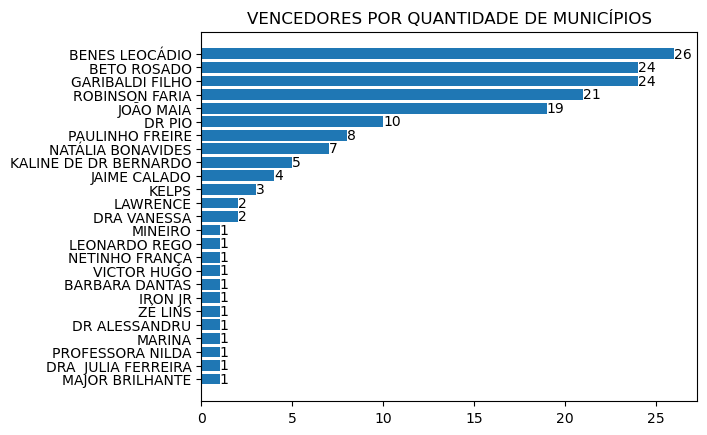

In [87]:
import matplotlib.pyplot as plt

pandas_df = df_def_fed_mun.toPandas()
pandas_df = pandas_df.sort_values(by='QT_MUNICIPIOS', ascending=True)

# Dados para o gráfico
categorias = pandas_df["NM_VOTAVEL"]
valores = pandas_df["QT_MUNICIPIOS"]

# Criação do gráfico de barras
plt.barh(categorias, valores)

# Adicionando os valores nas barras
for i, v in enumerate(valores):
    plt.text(v, i, str(v), color='black', va='center')

# Personalização do gráfico
plt.title('VENCEDORES POR QUANTIDADE DE MUNICÍPIOS')

# Exibição do gráfico
plt.show()
